# Utilities

In [1]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

# Get Values

In [2]:
ds = xr.open_dataset('CMIP6_amoc.nc')

In [3]:
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

In [4]:
strn26.load()
strn35.load()
index.load()

<xarray.DataArray 'index' (models: 34, ensemble_members: 10, year: 165)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -9.83567818,  -9.96747804,  -9.87559962, ...,  -9.8192265 ,
          -9.53018165,  -9.60423207],
        [ -9.26724124,  -9.20765185,  -9.62124856, ..., -10.28693318,
         -10.51233848, -10.22079849],
        [ -9.45160929,  -9.45961754,  -9.54747669, ..., -10.22823318,
         -10.1423463 ,  -9.9231437 ],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -8.9466881 ,  -9.2422324 ,  -9.27880526, ...,  -9.5742743 ,
          -9.38110113,  -9.47151629],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * models            (models) object 'AWI-CM-1-1-MR' ... 'SAM0-UNICON'
  * year              (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * ensemble_members  (ensemble_members) object 'r1i1p1f1' ... 'r10i1p1f1'

limit_output extension: Maximum message size of 10000 exceeded with 18219 characters

In [5]:
yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

# AMOC Strength - RAPID

In [6]:
obs_AMOC = xr.open_dataset('rapid_moc_transports.nc').moc_mar_hc10
obs_AMOCy = obs_AMOC.groupby('time.year').mean('time')
obs_AMOC_unc = 0.9

In [7]:
strn26_avg = (strn26.where(strn26.year>=2004,drop=True)).mean(dim='year')
obs_AMOCy_avg= (obs_AMOCy.where(obs_AMOCy.year<=2014)).mean(dim='year')

In [6]:
strn26_avg_full = strn26.mean(dim='year')


# SST Index and trend

In [10]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
otrend, intercept, r, p, se = linregress(oyear, oindex)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


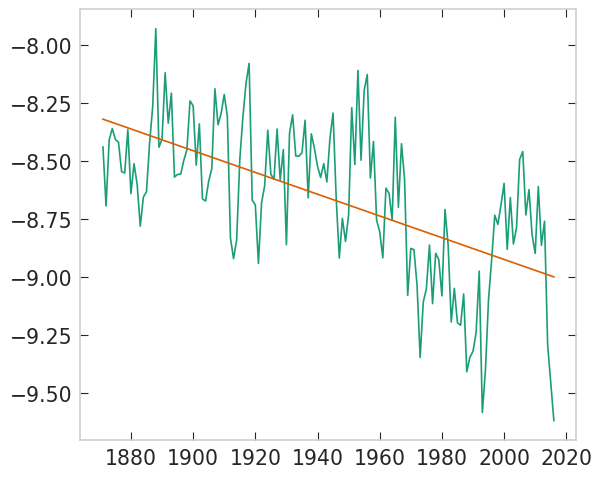

In [9]:
plt.plot(oyear,oindex)
plt.plot(oyear,oyear*otrend+intercept)
plt.show()

In [9]:
index_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        idx = np.nan_to_num(index.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, idx)
        index_trend[imod,iens]=slope*100 # trend of Sv/century

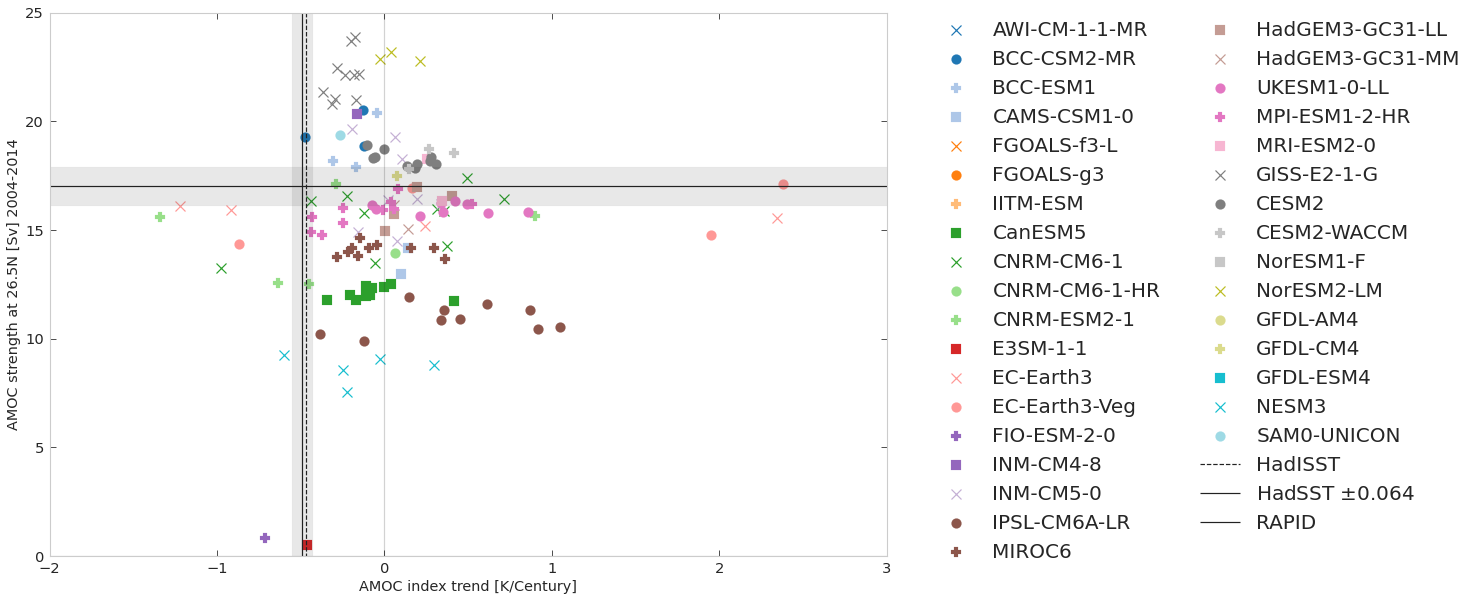

In [24]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','P','s']
o_trend = otrend*100

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend[i],strn26_avg[i],color=col,label=mod,marker=marker,s=100)
plt.vlines(o_trend,-10,30,color='k',label='HadISST',linestyle='--')
# plt.fill_betweenx([-10,30],o_trend-0.15,o_trend+0.15,color='k',alpha=0.05)
plt.vlines(-0.49,-10,30,color='k',label='HadSST $\pm 0.064$',linestyle='-')
plt.fill_betweenx([-10,30],-0.49-0.064,-0.49+0.064,color='k',alpha=0.1)
plt.hlines(obs_AMOCy_avg,-10,30,color='k',label='RAPID')
plt.fill_between([-10,30],obs_AMOCy_avg-obs_AMOC_unc,obs_AMOCy_avg+obs_AMOC_unc,color='k',alpha=0.1)
ax.set_xlim(-2,3)
ax.set_ylim(0,25)
plt.hlines(0,-10,30,color='k',alpha=0.2)
plt.vlines(0,-10,30,color='k',alpha=0.2)
plt.ylabel('AMOC strength at 26.5N [Sv] 2004-2014')
plt.xlabel('AMOC index trend [K/Century]')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)

# ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()

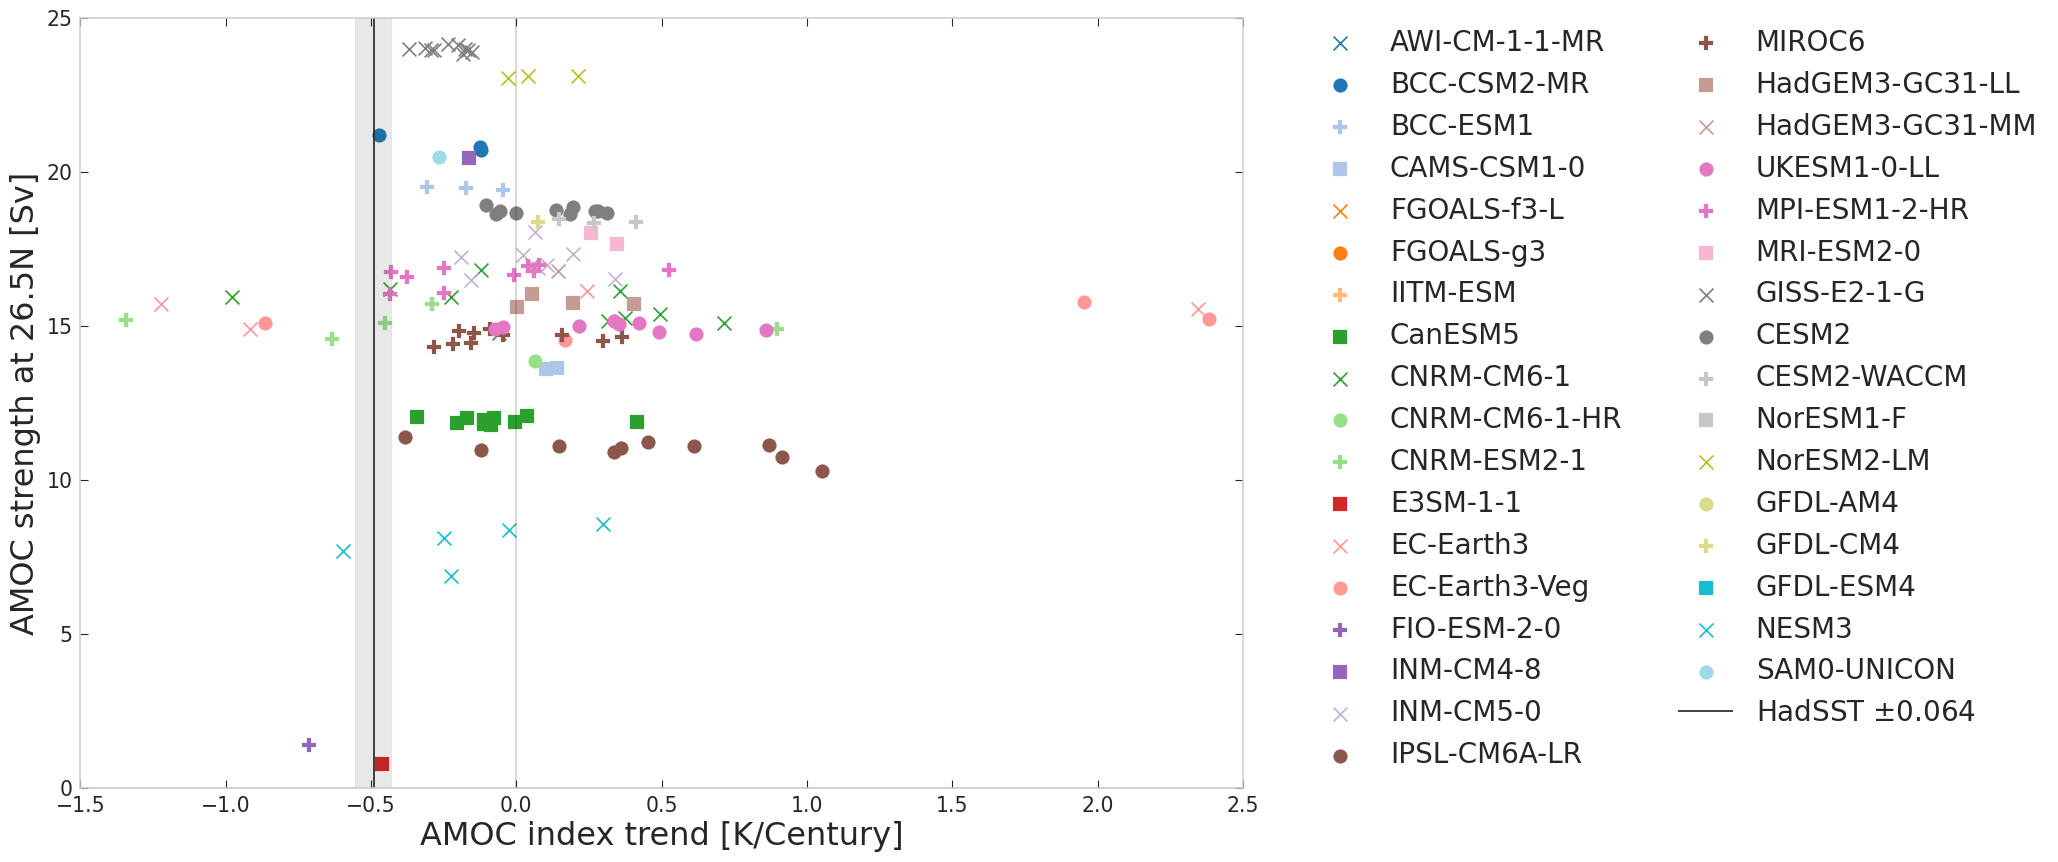

In [14]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','P','s']
o_trend = otrend*100

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend[i],strn26_avg_full[i],color=col,label=mod,marker=marker,s=100)
# plt.vlines(o_trend,-10,30,color='k',label='HadISST',linestyle='--')
# plt.fill_betweenx([-10,30],o_trend-0.15,o_trend+0.15,color='k',alpha=0.05)
plt.vlines(-0.49,-10,30,color='k',label='HadSST $\pm 0.064$',linestyle='-')
plt.fill_betweenx([-10,30],-0.49-0.064,-0.49+0.064,color='k',alpha=0.1)
# plt.hlines(obs_AMOCy_avg,-10,30,color='k',label='RAPID')
# plt.fill_between([-10,30],obs_AMOCy_avg-obs_AMOC_unc,obs_AMOCy_avg+obs_AMOC_unc,color='k',alpha=0.1)
ax.set_xlim(-1.5,2.5)
ax.set_ylim(0,25)
plt.hlines(0,-10,30,color='k',alpha=0.2)
plt.vlines(0,-10,30,color='k',alpha=0.2)
plt.ylabel('AMOC strength at 26.5N [Sv]')
plt.xlabel('AMOC index trend [K/Century]')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)

# ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()

# AMOC lambda trend

In [12]:
lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
lambda_pvs = xr.open_dataset('EWS_files/CMIP6_lambda_pvs.nc')
lambda_trends = xr.open_dataset('EWS_files/CMIP6_lambda_trends.nc')

In [13]:
EWS_index = lambda_pvs.where(
           (lambda_pvs.index_pvs<=0.05))
idcs = ~np.isnan(EWS_index.index_pvs.values)


EWS_any = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=0.05) |
            (lambda_pvs.strn35_pvs<=0.05) |
            (lambda_pvs.index_pvs<=0.05)))
idcs_any = ~np.isnan(EWS_any.index_pvs.values)



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


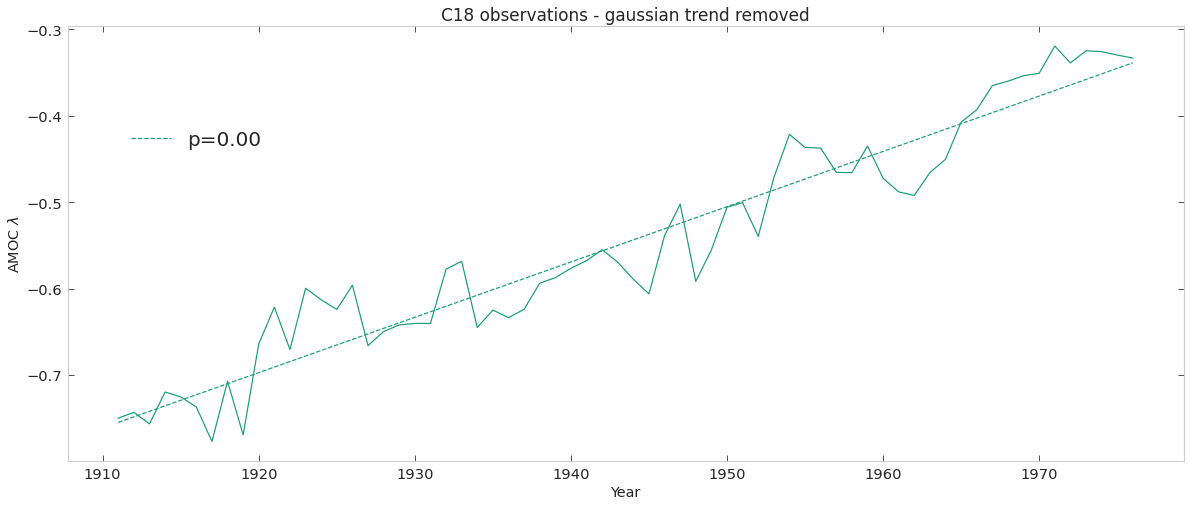

In [14]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
otrend, intercept, r, p, se = linregress(oyear, oindex)


oamoc_low = gaussian_filter1d(oindex, 10)
lam = run_fit_a_ar1(np.array((oindex-oamoc_low)[5:-5]),70)
bound = 70 // 2
tt = oyear[5:-5][bound:-bound]
p0, p1 = np.polyfit(tt[:-2], lam[bound:-bound][:-2], 1)
pv = kendall_tau_test(lam[bound:-bound][:-2], 10000, p0)
o_lambda_trend = p0
o_lambda_pv = pv

%matplotlib inline
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)

ax.plot(oyear[5:-5],lam,color='C0')
ax.plot(tt,tt*p0+p1,linestyle='--',color='C0',label='p={:.2f}'.format(o_lambda_pv))
# plt.xlim(1880,2022)
ax.set_ylabel('AMOC $\lambda$')
ax.set_xlabel('Year')
ax.set_title('C18 observations - gaussian trend removed')
ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
plt.show()

In [15]:
o_lambda_trend1 = 0.004
o_lambda_trend_unc = 0.002

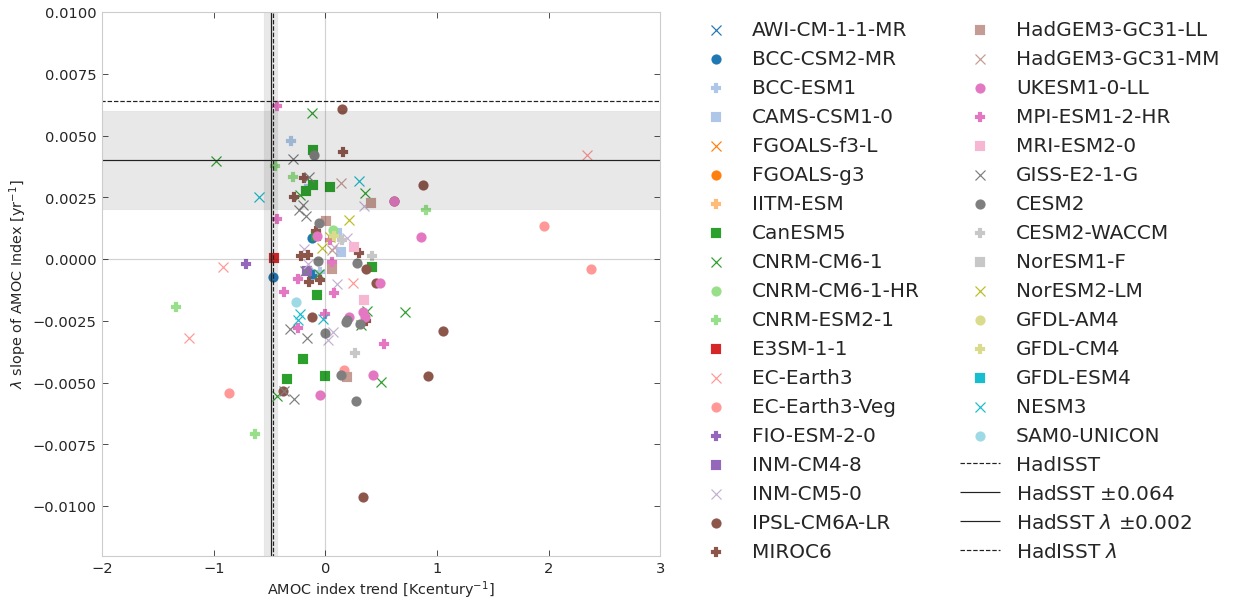

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','P','s']
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend[i],lambda_trends.index_trends.values[i],color=col,label=mod,marker=marker,s=100)
# plt.scatter(lambda_trends.index_trends.values,lambda_trends.strn26_trends.values)
plt.vlines(o_trend,-10,30,color='k',label='HadISST',linestyle='--')
# plt.fill_betweenx([-10,30],o_trend-0.15,o_trend+0.15,color='k',alpha=0.05)
plt.vlines(-0.49,-10,30,color='k',label='HadSST $\pm 0.064$',linestyle='-')
plt.fill_betweenx([-10,30],-0.49-0.064,-0.49+0.064,color='k',alpha=0.1)
plt.hlines(o_lambda_trend1,-10,30,color='k',label='HadSST $\lambda$ $\pm0.002$')
plt.hlines(o_lambda_trend,-10,30,color='k',label='HadISST $\lambda$',linestyle='--')
plt.fill_between([-10,30],o_lambda_trend1-o_lambda_trend_unc,o_lambda_trend1+o_lambda_trend_unc,color='k',alpha=0.1)
ax.set_ylim(-0.012,0.01)
ax.set_xlim(-2,3)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.xlabel('AMOC index trend [Kcentury$^{-1}$]')
plt.ylabel('$\lambda$ slope of AMOC Index [yr$^{-1}$]')
plt.show()
plt.show()

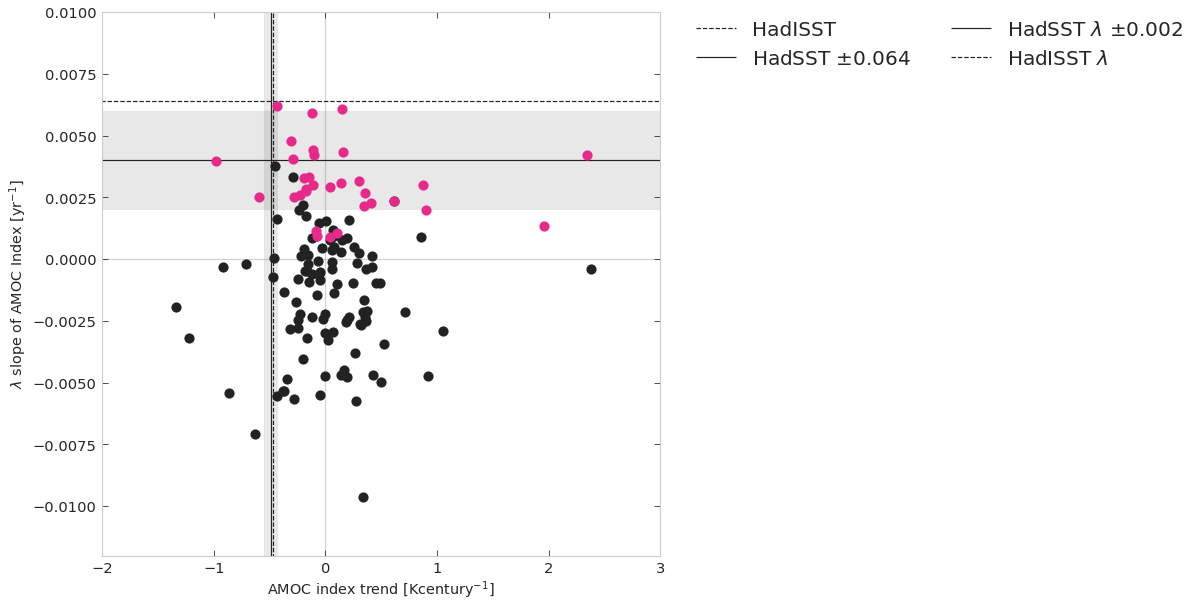

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','P','s']
for i, mod in enumerate(models):
    for j in range(10):
        if idcs[i,j]:
            plt.scatter(index_trend[i,j],lambda_trends.index_trends.values[i,j],color='C3',marker='o',s=100,zorder=20)
        else:
            plt.scatter(index_trend[i,j],lambda_trends.index_trends.values[i,j],color='k',marker='o',s=100)
# for i, mod in enumerate(models):
#     marker = markers[i%4]
#     col = color_list[i]
#     plt.scatter(index_trend[i],lambda_trends.index_trends.values[i],color=col,label=mod,marker=marker,s=100)
# plt.scatter(lambda_trends.index_trends.values,lambda_trends.strn26_trends.values)
plt.vlines(o_trend,-10,30,color='k',label='HadISST',linestyle='--')
# plt.fill_betweenx([-10,30],o_trend-0.15,o_trend+0.15,color='k',alpha=0.05)
plt.vlines(-0.49,-10,30,color='k',label='HadSST $\pm 0.064$',linestyle='-')
plt.fill_betweenx([-10,30],-0.49-0.064,-0.49+0.064,color='k',alpha=0.1)
plt.hlines(o_lambda_trend1,-10,30,color='k',label='HadSST $\lambda$ $\pm0.002$')
plt.hlines(o_lambda_trend,-10,30,color='k',label='HadISST $\lambda$',linestyle='--')
plt.fill_between([-10,30],o_lambda_trend1-o_lambda_trend_unc,o_lambda_trend1+o_lambda_trend_unc,color='k',alpha=0.1)
ax.set_ylim(-0.012,0.01)
ax.set_xlim(-2,3)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.xlabel('AMOC index trend [Kcentury$^{-1}$]')
plt.ylabel('$\lambda$ slope of AMOC Index [yr$^{-1}$]')
plt.show()
plt.show()

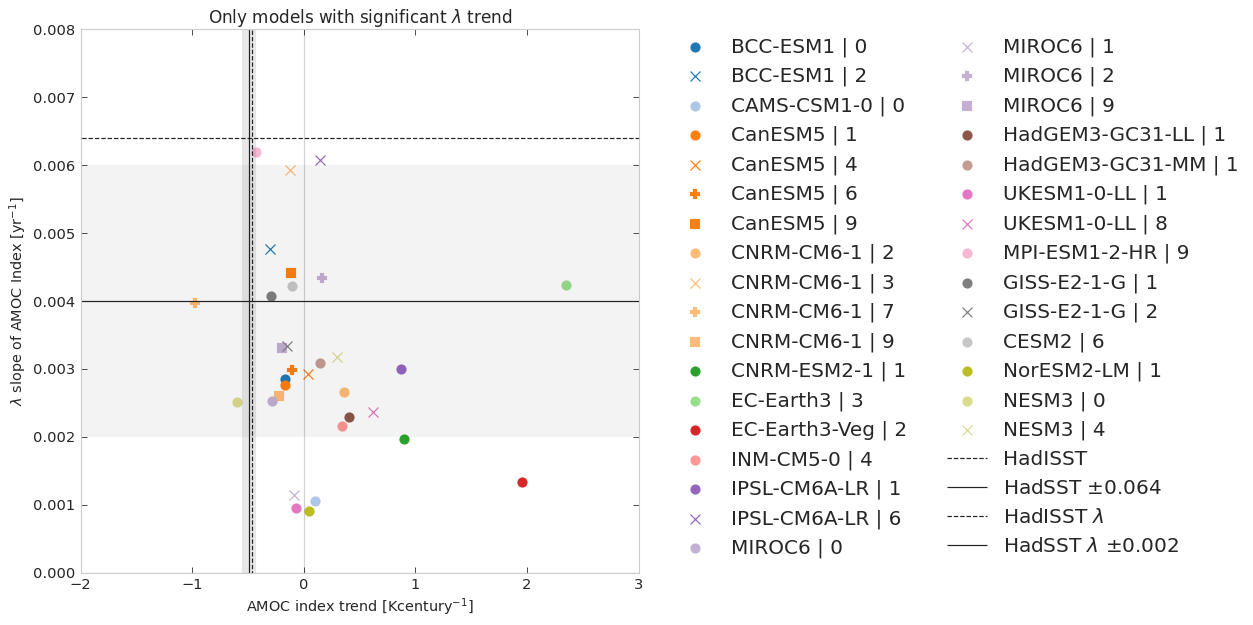

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/20) for i in np.arange(0,20)]
markers = ['o','x','P','s']
ic = 0
for i, mod in enumerate(models):
    col = color_list[ic]
    x = 0
    for j in range(10):
        marker = markers[x%4]
        if idcs[i,j]:
            plt.scatter(index_trend[i,j],lambda_trends.index_trends.values[i,j],color=col,label='{} | {}'.format(mod,j),marker=marker,s=100)
            x = x+1
    if x!=0:
        ic = ic +1
            # plt.scatter(lambda_trends.index_trends.values,lambda_trends.strn26_trends.values)
plt.vlines(o_trend,-10,30,color='k',label='HadISST',linestyle='--')
# plt.fill_betweenx([-10,30],o_trend-0.15,o_trend+0.15,color='k',alpha=0.05)
plt.vlines(-0.49,-10,30,color='k',label='HadSST $\pm 0.064$',linestyle='-')
plt.fill_betweenx([-10,30],-0.49-0.064,-0.49+0.064,color='k',alpha=0.1)

plt.hlines(o_lambda_trend,-10,30,color='k',label='HadISST $\lambda$',linestyle='--')
plt.hlines(o_lambda_trend1,-10,30,color='k',label='HadSST $\lambda$ $\pm0.002$')
plt.fill_between([-10,30],o_lambda_trend1-o_lambda_trend_unc,o_lambda_trend1+o_lambda_trend_unc,color='k',alpha=0.05)
ax.set_ylim(0,0.008)
ax.set_xlim(-2,3)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.xlabel('AMOC index trend [Kcentury$^{-1}$]')
plt.ylabel('$\lambda$ slope of AMOC Index [yr$^{-1}$]')
ax.set_title('Only models with significant $\lambda$ trend')
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


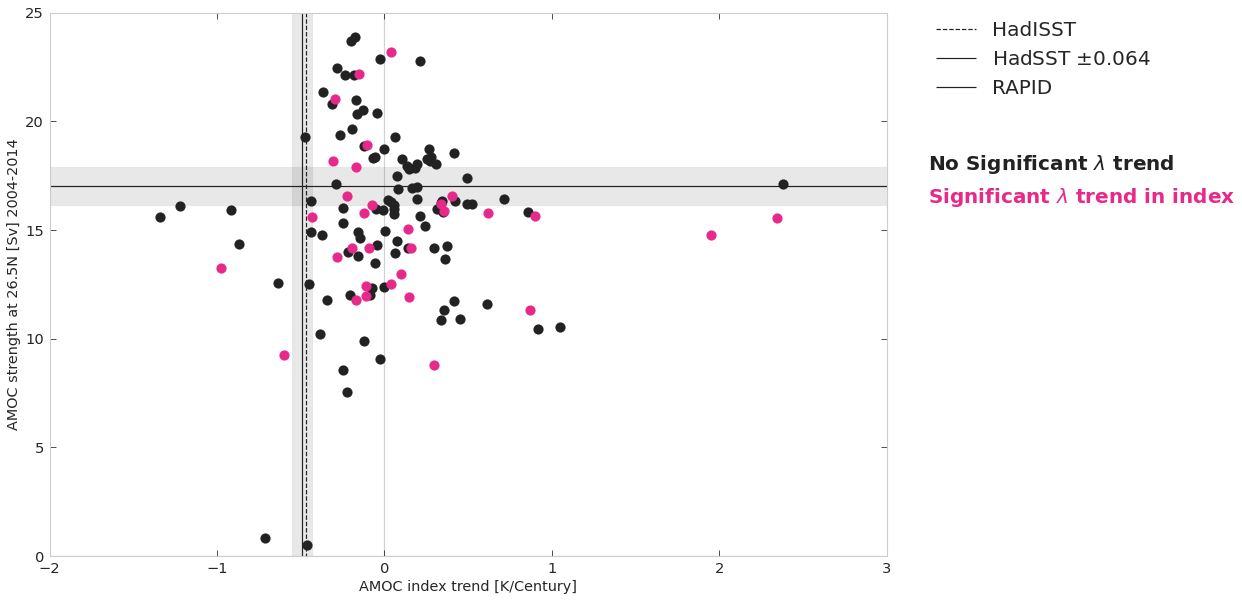

In [19]:
o_trend = otrend*100

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    for j in range(10):
        if idcs[i,j]:
            plt.scatter(index_trend[i,j],strn26_avg[i,j],color='C3',marker='o',s=100,zorder=20)
        else:
            plt.scatter(index_trend[i,j],strn26_avg[i,j],color='k',marker='o',s=100)

plt.vlines(o_trend,-10,30,color='k',label='HadISST',linestyle='--')
# plt.fill_betweenx([-10,30],o_trend-0.15,o_trend+0.15,color='k',alpha=0.05)
plt.vlines(-0.49,-10,30,color='k',label='HadSST $\pm 0.064$',linestyle='-')
plt.fill_betweenx([-10,30],-0.49-0.064,-0.49+0.064,color='k',alpha=0.1)
plt.hlines(obs_AMOCy_avg,-10,30,color='k',label='RAPID')
plt.fill_between([-10,30],obs_AMOCy_avg-obs_AMOC_unc,obs_AMOCy_avg+obs_AMOC_unc,color='k',alpha=0.1)
ax.set_xlim(-2,3)
ax.set_ylim(0,25)
plt.hlines(0,-10,30,color='k',alpha=0.2)
plt.vlines(0,-10,30,color='k',alpha=0.2)
plt.ylabel('AMOC strength at 26.5N [Sv] 2004-2014')
plt.xlabel('AMOC index trend [K/Century]')
ax.text(1.05, 0.71, 'No Significant $\lambda$ trend', color='k', transform=ax.transAxes, fontsize=fontsize+4,fontweight='bold')
ax.text(1.05, 0.65, 'Significant $\lambda$ trend in index', color='C3', transform=ax.transAxes, fontsize=fontsize+4,fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=1)

plt.show()

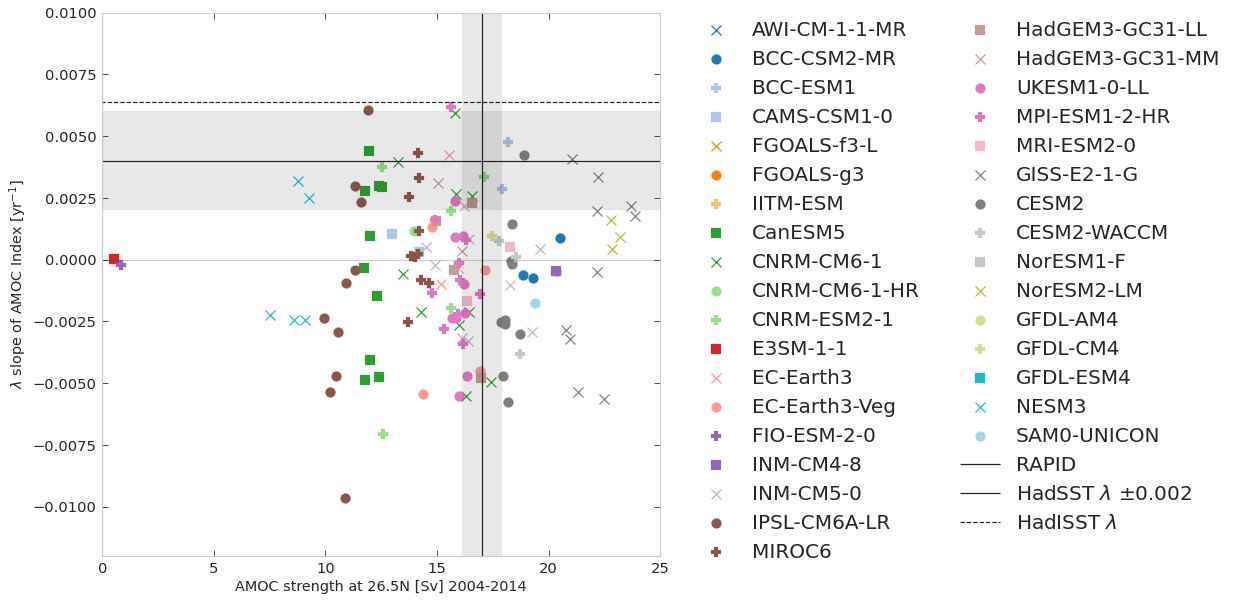

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','P','s']
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(strn26_avg[i],lambda_trends.index_trends.values[i],color=col,label=mod,marker=marker,s=100)
plt.fill_betweenx([-10,30],obs_AMOCy_avg-obs_AMOC_unc,obs_AMOCy_avg+obs_AMOC_unc,color='k',alpha=0.1)
plt.vlines(obs_AMOCy_avg,-10,30,color='k',label='RAPID')
plt.hlines(o_lambda_trend1,-10,30,color='k',label='HadSST $\lambda$ $\pm0.002$')
plt.hlines(o_lambda_trend,-10,30,color='k',label='HadISST $\lambda$',linestyle='--')
plt.fill_between([-10,30],o_lambda_trend1-o_lambda_trend_unc,o_lambda_trend1+o_lambda_trend_unc,color='k',alpha=0.1)
ax.set_ylim(-0.012,0.01)
ax.set_xlim(0,25)
plt.hlines(0,-10,30,color='k',alpha=0.2)
plt.vlines(0,-10,30,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.xlabel('AMOC strength at 26.5N [Sv] 2004-2014')
plt.ylabel('$\lambda$ slope of AMOC Index [yr$^{-1}$]')
plt.show()
plt.show()

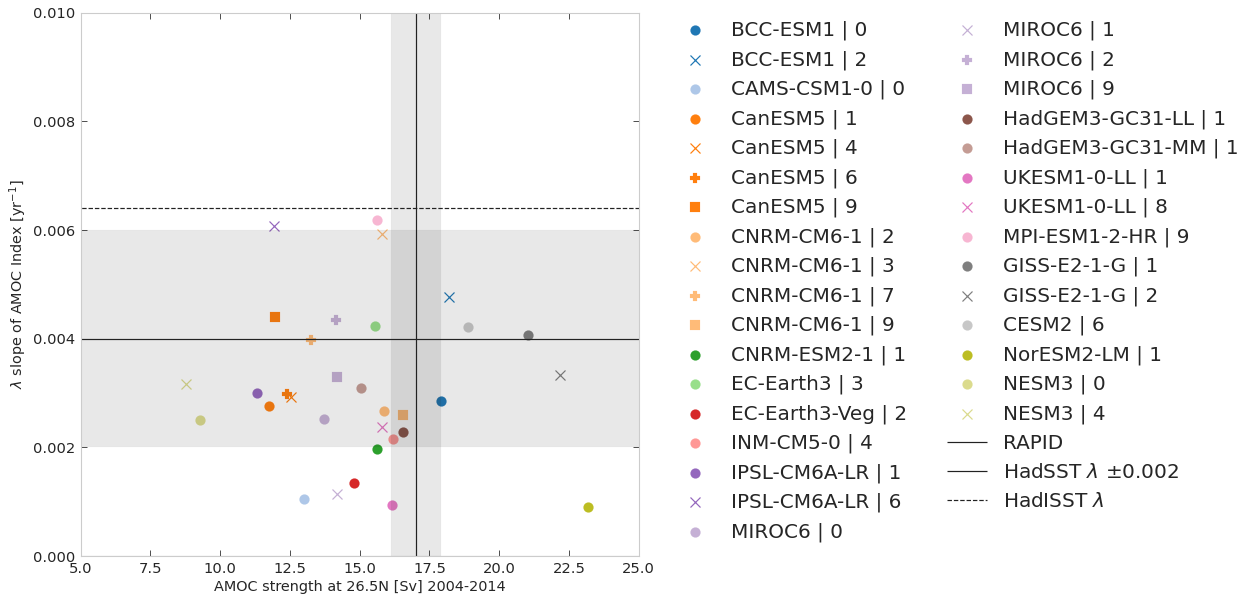

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/20) for i in np.arange(0,20)]
markers = ['o','x','P','s']
ic = 0
for i, mod in enumerate(models):
    col = color_list[ic]
    x = 0
    for j in range(10):
        marker = markers[x%4]
        if idcs[i,j]:
            plt.scatter(strn26_avg[i,j],lambda_trends.index_trends.values[i,j],color=col,label='{} | {}'.format(mod,j),marker=marker,s=100)
            x = x+1
    if x!=0:
        ic = ic +1
            # plt.scatter(lambda_trends.index_trends.values,lambda_trends.strn26_trends.values)
plt.fill_betweenx([-10,30],obs_AMOCy_avg-obs_AMOC_unc,obs_AMOCy_avg+obs_AMOC_unc,color='k',alpha=0.1)
plt.vlines(obs_AMOCy_avg,-10,30,color='k',label='RAPID')
plt.hlines(o_lambda_trend1,-10,30,color='k',label='HadSST $\lambda$ $\pm0.002$')
plt.hlines(o_lambda_trend,-10,30,color='k',label='HadISST $\lambda$',linestyle='--')
plt.fill_between([-10,30],o_lambda_trend1-o_lambda_trend_unc,o_lambda_trend1+o_lambda_trend_unc,color='k',alpha=0.1)
ax.set_ylim(0,0.01)
ax.set_xlim(5,25)
plt.hlines(0,-10,30,color='k',alpha=0.2)
plt.vlines(0,-10,30,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.xlabel('AMOC strength at 26.5N [Sv] 2004-2014')
plt.ylabel('$\lambda$ slope of AMOC Index [yr$^{-1}$]')
plt.show()
plt.show()

In [22]:
strn26_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn26.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn26_trend[imod,iens]=slope*100 # trend of Sv/century
index_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        idx = np.nan_to_num(index.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, idx)
        index_trend[imod,iens]=slope*100 # trend of Sv/century
strn35_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn35.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn35_trend[imod,iens]=slope*100 # trend of Sv/century

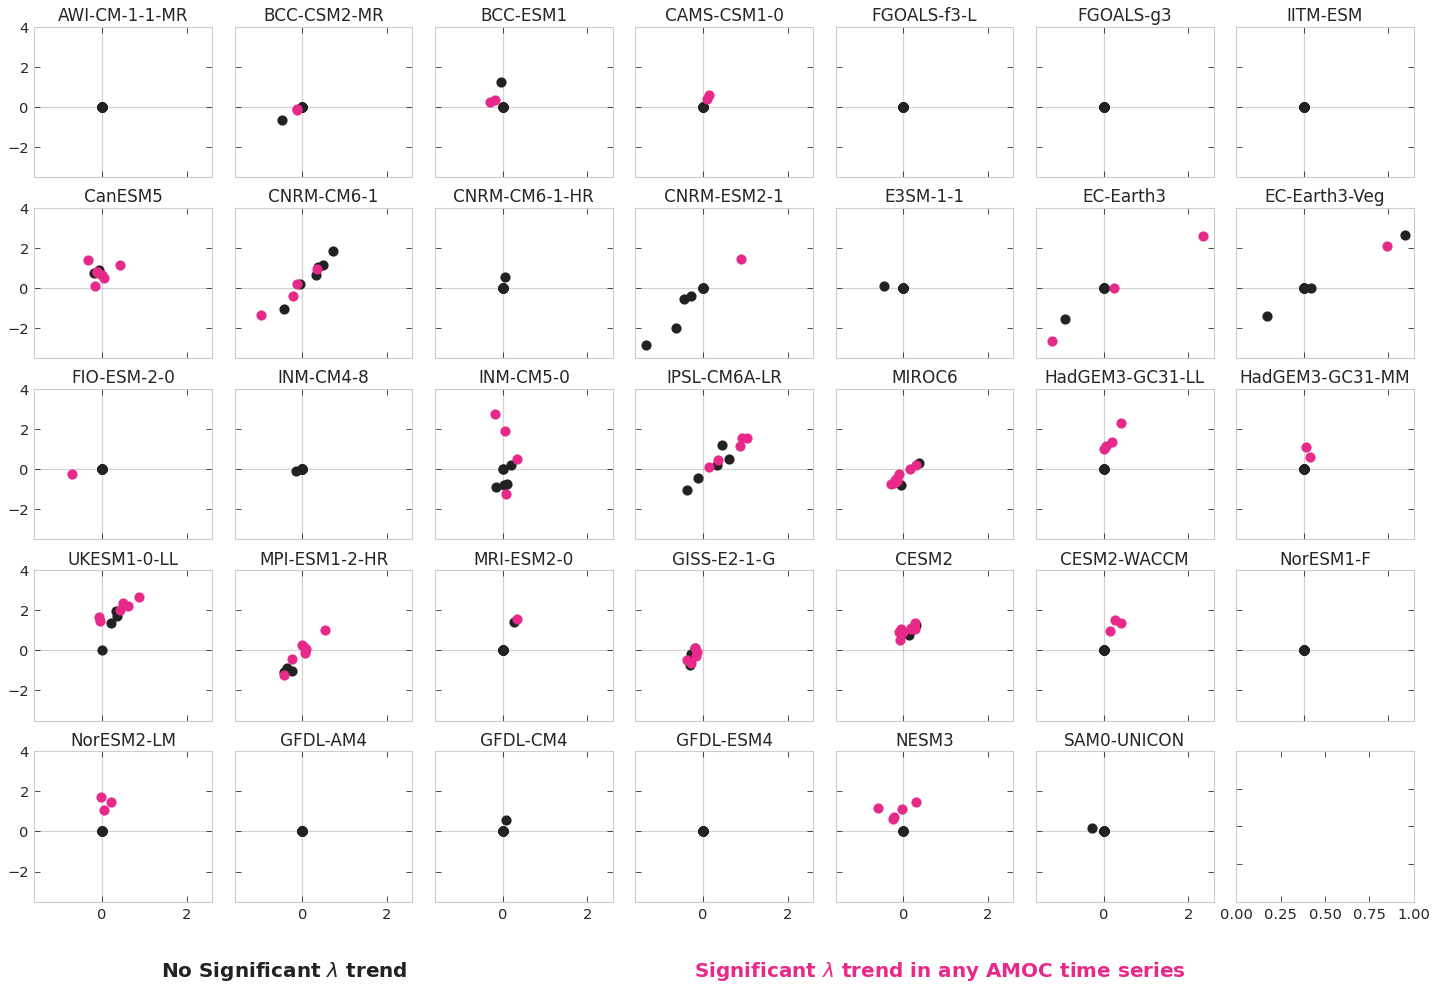

In [23]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig, axs = plt.subplots(5,7,figsize = (20,13))
for i, ax in enumerate(axs.flatten()):
    if i<=33:
        mod = models[i]
        marker = markers[i%4]
        col = color_list[i]
        for j in range(10):
            if idcs_any[i,j]:
                ax.scatter(index_trend[i,j],strn26_trend[i,j],color='C3',label=mod,marker='o',s=100,zorder=20)
            else:
                ax.scatter(index_trend[i,j],strn26_trend[i,j],color='k',label=mod,marker='o',s=100)
        ax.set_ylim(-3.5,4)
        ax.set_xlim(-1.6,2.6)
        ax.hlines(0,-10,10,color='k',alpha=0.2)
        ax.vlines(0,-10,10,color='k',alpha=0.2)
        ax.set_title(mod)
    if not ((i==0) or (i==7) or (i==14) or (i==21) or (i==28)):
        ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
    if not (i>=28):
        ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)

fig.tight_layout()
            
# ax.set_ylabel('AMOC strength trend at 26.5N [Sv/Century]')
# ax.set_xlabel('AMOC index trend [K/Century]')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
ax.text(-6.05, -0.5, 'No Significant $\lambda$ trend', color='k', transform=ax.transAxes, fontsize=fontsize+4,fontweight='bold')
ax.text(-3.05, -0.5, 'Significant $\lambda$ trend in any AMOC time series', color='C3', transform=ax.transAxes, fontsize=fontsize+4,fontweight='bold')

# fig.supxlabel('AMOC Strength at 26.5N [Sv]')
# ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()